In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np

df = pd.read_csv('random_forest_predictions_with_actuals.csv')
print(df.head())

                    run_date            target_datetime  predicted_Price  \
0  2025-03-15 00:00:00+00:00  2025-03-16 01:00:00+00:00         0.093036   
1  2025-03-15 00:00:00+00:00  2025-03-16 02:00:00+00:00         0.091816   
2  2025-03-15 00:00:00+00:00  2025-03-16 03:00:00+00:00         0.092445   
3  2025-03-15 00:00:00+00:00  2025-03-16 04:00:00+00:00         0.093663   
4  2025-03-15 00:00:00+00:00  2025-03-16 05:00:00+00:00         0.093793   

   actual_Price  oxygent_price  naive_price  
0       0.08579          0.083      0.08680  
1       0.07962          0.079      0.08570  
2       0.07818          0.074      0.09586  
3       0.07860          0.073      0.09772  
4       0.08051          0.076      0.09985  


# GENERAL PERFORMANCE METRICS


In [2]:
# Calculate missing values count and percentage
missing_values = pd.DataFrame({
    'Missing Count': df.isnull().sum(),
    'Missing Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})
print(missing_values)

                 Missing Count  Missing Percentage
run_date                     0                0.00
target_datetime              0                0.00
predicted_Price              0                0.00
actual_Price                 0                0.00
oxygent_price                6                0.14
naive_price                  0                0.00


In [3]:
df['oxygent_price'] = df['oxygent_price'].fillna(df['predicted_Price'])

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate metrics for each model
results = {
    'Model': ['Random Forest', 'Oxygent', 'Naive'],
    'RMSE': [
        np.sqrt(mean_squared_error(df['actual_Price'], df['predicted_Price'])),
        np.sqrt(mean_squared_error(df['actual_Price'], df['oxygent_price'])),
        np.sqrt(mean_squared_error(df['actual_Price'], df['naive_price']))
    ],
    'MAE': [
        mean_absolute_error(df['actual_Price'], df['predicted_Price']),
        mean_absolute_error(df['actual_Price'], df['oxygent_price']),
        mean_absolute_error(df['actual_Price'], df['naive_price'])
    ]
}

# Create results DataFrame and round to 6 decimal places
results_df = pd.DataFrame(results).round(6)
print(results_df)

           Model      RMSE       MAE
0  Random Forest  0.035374  0.025476
1        Oxygent  0.077176  0.058853
2          Naive  0.042212  0.030525


In [5]:
import numpy as np
# Count number of samples per forecast horizon
df['forecast_horizon'] = np.ceil((pd.to_datetime(df['target_datetime']) - pd.to_datetime(df['run_date'])).dt.total_seconds()/(24*3600))
print(df['forecast_horizon'].value_counts().sort_index())

forecast_horizon
2.0    720
3.0    720
4.0    720
5.0    720
6.0    720
7.0    720
Name: count, dtype: int64


In [25]:
# RMSE for different forecast horizons using a DataFrame.
# Initialize empty dictionary with lists
horizon_results = {
    'Horizon': [],
    'Random Forest': [],
    'Oxygent': [],
    'Naive': []
}
# Get unique horizons from the DataFrame
horizons = sorted(df['forecast_horizon'].unique())

# Initialize empty dictionary with lists
horizon_results = {
    'Horizon': [],
    'Random Forest': [],
    'Oxygent': [],
    'Naive': []
}

# Fill lists with results
for h in horizons:
    horizon_data = df[df['forecast_horizon'] == h]
    horizon_results['Horizon'].append(h)
    horizon_results['Random Forest'].append(np.sqrt(mean_squared_error(horizon_data['actual_Price'], horizon_data['predicted_Price'])))
    horizon_results['Oxygent'].append(np.sqrt(mean_squared_error(horizon_data['actual_Price'], horizon_data['oxygent_price'])))
    horizon_results['Naive'].append(np.sqrt(mean_squared_error(horizon_data['actual_Price'], horizon_data['naive_price'])))

# Create and format results DataFrame
horizon_results_df = pd.DataFrame(horizon_results).set_index('Horizon').round(4)
print(horizon_results_df)


         Random Forest  Oxygent   Naive
Horizon                                
2.0             0.0356   0.0749  0.0426
3.0             0.0355   0.0829  0.0428
4.0             0.0361   0.0775  0.0427
5.0             0.0350   0.0787  0.0422
6.0             0.0339   0.0762  0.0419
7.0             0.0361   0.0725  0.0411


In [9]:
# Calculate bias and metrics for each model
bias_results = {
    'Model': ['Random Forest', 'Oxygent', 'Naive'],
    'Bias': [
        (df['predicted_Price'] - df['actual_Price']).mean(),
        (df['oxygent_price'] - df['actual_Price']).mean(),
        (df['naive_price'] - df['actual_Price']).mean()
    ],
    'MAE': [
        mean_absolute_error(df['actual_Price'], df['predicted_Price']),
        mean_absolute_error(df['actual_Price'], df['oxygent_price']),
        mean_absolute_error(df['actual_Price'], df['naive_price'])
    ],
    'RMSE': [
        np.sqrt(mean_squared_error(df['actual_Price'], df['predicted_Price'])),
        np.sqrt(mean_squared_error(df['actual_Price'], df['oxygent_price'])),
        np.sqrt(mean_squared_error(df['actual_Price'], df['naive_price']))
    ]
}

# Create DataFrame and round results to 6 decimal places
bias_results_df = pd.DataFrame(bias_results).round(6)
print(bias_results_df)

           Model      Bias       MAE      RMSE
0  Random Forest  0.003132  0.025476  0.035374
1        Oxygent  0.006267  0.058853  0.077176
2          Naive  0.006511  0.030525  0.042212


De **bias**-waarden geven aan of een model structureel te hoog of te laag voorspelt ten opzichte van de werkelijke waarde:

- **Bias = gemiddeld(Voorspelling - Werkelijk)**  
  - Een **positieve bias** betekent dat het model gemiddeld te hoge waarden voorspelt (overschatting).
  - Een **negatieve bias** betekent dat het model gemiddeld te lage waarden voorspelt (onderschatting).
  - Een **bias dichtbij 0** betekent dat het model gemiddeld genomen geen structurele overschatting of onderschatting heeft.

**Voorbeeld:**  
- Bias van +2: het model voorspelt gemiddeld 2 eenheden te hoog.
- Bias van -1.5: het model voorspelt gemiddeld 1.5 eenheden te laag.

**Let op:**  
Een lage bias betekent niet automatisch dat het model goed is; het kan nog steeds grote fouten maken (hoge MAE of RMSE), zolang de overschattingen en onderschattingen elkaar maar ongeveer opheffen. Bias zegt dus alleen iets over de richting van de systematische fout, niet over de spreiding van de fouten.

# PERFORMANCE RELATIVE TO CHEAPEST & MOST EXPENSIVE HOURS, WITHIN EACH RUN (SO 6 DAYS HORIZON)

In [23]:
# Initialize results dictionary
comparison_results = {
    'model': [],
    'avg_overlap_cheap': [],
    'avg_overlap_expensive': [],
    'avg_price_diff_cheap': [],
    'avg_price_diff_expensive': []
}

# Get unique run dates
run_dates = df['run_date'].unique()

# Analyze each run_date
for run_date in run_dates:
    # Get data for current run date
    day_data = df[df['run_date'] == run_date]
    
    # Find cheapest and most expensive 4-hour blocks
    # Calculate rolling mean for 4-hour blocks
    rolling_means = day_data['actual_Price'].rolling(window=4).mean()
    
    # Find start index of cheapest and most expensive blocks
    cheap_block_start = rolling_means.idxmin()
    expensive_block_start = rolling_means.idxmax()
    
    # Get actual cheapest and most expensive blocks
    actual_cheap = day_data.loc[cheap_block_start:cheap_block_start+3]
    actual_expensive = day_data.loc[expensive_block_start:expensive_block_start+3]
    
    # Calculate actual average prices for reference
    actual_cheap_avg = actual_cheap['actual_Price'].mean()
    actual_expensive_avg = actual_expensive['actual_Price'].mean()
    
    # Analyze each model
    for model in ['predicted_Price', 'oxygent_price', 'naive_price']:
        model_name = 'Random Forest' if model == 'predicted_Price' else ('Oxygent' if model == 'oxygent_price' else 'Naive')
        
        # Find model's predicted cheapest and most expensive blocks
        model_rolling_means = day_data[model].rolling(window=4).mean()
        model_cheap_start = model_rolling_means.idxmin()
        model_expensive_start = model_rolling_means.idxmax()
        
        model_cheap = day_data.loc[model_cheap_start:model_cheap_start+3]
        model_expensive = day_data.loc[model_expensive_start:model_expensive_start+3]
        
        # Calculate overlaps (number of hours that overlap)
        cheap_overlap = len(set(model_cheap.index) & set(actual_cheap.index))
        expensive_overlap = len(set(model_expensive.index) & set(actual_expensive.index))
        
        # Calculate average prices for model's selections
        model_cheap_actual_avg = day_data.loc[model_cheap.index, 'actual_Price'].mean()
        model_expensive_actual_avg = day_data.loc[model_expensive.index, 'actual_Price'].mean()
        
        # Store results
        if model_name not in comparison_results['model']:
            comparison_results['model'].append(model_name)
            comparison_results['avg_overlap_cheap'].append([])
            comparison_results['avg_overlap_expensive'].append([])
            comparison_results['avg_price_diff_cheap'].append([])
            comparison_results['avg_price_diff_expensive'].append([])
        
        idx = comparison_results['model'].index(model_name)
        comparison_results['avg_overlap_cheap'][idx].append(cheap_overlap)
        comparison_results['avg_overlap_expensive'][idx].append(expensive_overlap)
        comparison_results['avg_price_diff_cheap'][idx].append(model_cheap_actual_avg - actual_cheap_avg)
        comparison_results['avg_price_diff_expensive'][idx].append(actual_expensive_avg - model_expensive_actual_avg)

# Calculate final averages
final_results = pd.DataFrame({
    'Model': comparison_results['model'],
    'Avg Overlap Cheap Hours': [np.mean(x) for x in comparison_results['avg_overlap_cheap']],
    'Avg Overlap Expensive Hours': [np.mean(x) for x in comparison_results['avg_overlap_expensive']],
    'Avg Price Diff Cheap (€)': [np.mean(x) for x in comparison_results['avg_price_diff_cheap']],
    'Avg Price Diff Expensive (€)': [np.mean(x) for x in comparison_results['avg_price_diff_expensive']]
}).round(4)

print(final_results)

           Model  Avg Overlap Cheap Hours  Avg Overlap Expensive Hours  \
0  Random Forest                   1.4667                       1.5000   
1        Oxygent                   1.4000                       0.1333   
2          Naive                   0.9000                       1.9333   

   Avg Price Diff Cheap (€)  Avg Price Diff Expensive (€)  
0                    0.0233                        0.0041  
1                    0.0350                        0.0777  
2                    0.0234                        0.0032  


Forecast hours range from 25 to 168


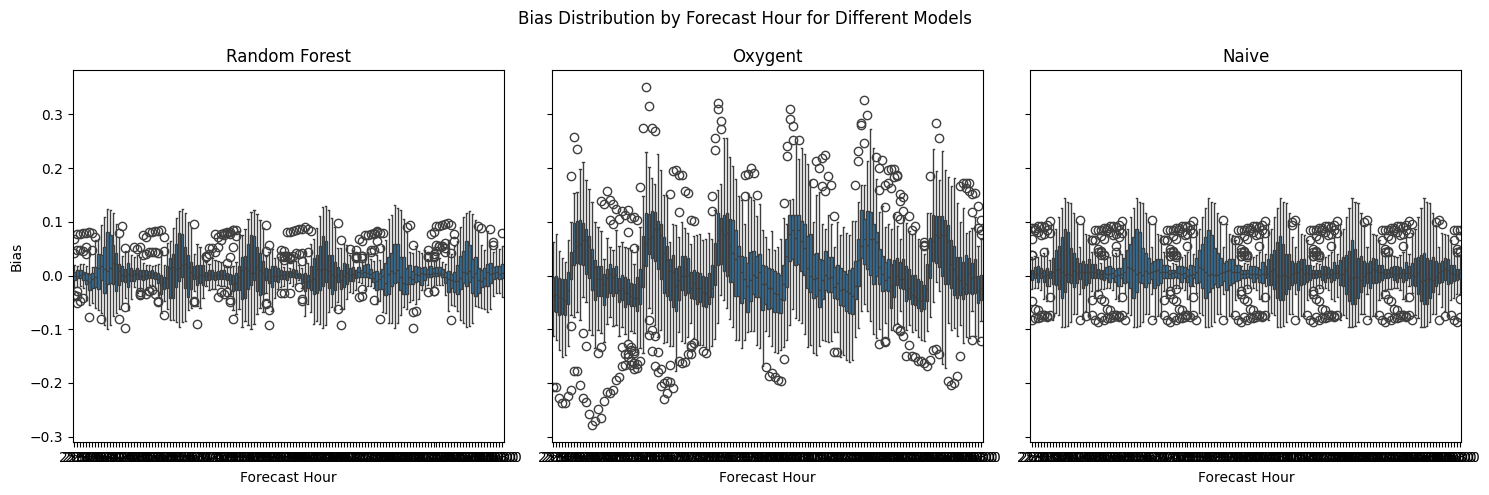

In [13]:
import seaborn as sns

import matplotlib.pyplot as plt

# 1. Add forecast_hour column
df['forecast_hour'] = (pd.to_datetime(df['target_datetime']) - pd.to_datetime(df['run_date'])).dt.total_seconds()/3600

# 2. Get min and max forecast hours
min_hour = df['forecast_hour'].min()
max_hour = df['forecast_hour'].max()
print(f"Forecast hours range from {min_hour:.0f} to {max_hour:.0f}")

# 3. Calculate bias and create plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Bias Distribution by Forecast Hour for Different Models')

models = ['predicted_Price', 'oxygent_price', 'naive_price']
names = ['Random Forest', 'Oxygent', 'Naive']

for i, (model, name) in enumerate(zip(models, names)):
    # Calculate bias
    df[f'bias_{model}'] = df[model] - df['actual_Price']
    
    # Create boxplot
    sns.boxplot(data=df, x='forecast_hour', y=f'bias_{model}', ax=axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel('Forecast Hour')
    axes[i].set_ylabel('Bias' if i==0 else '')
    
plt.tight_layout()

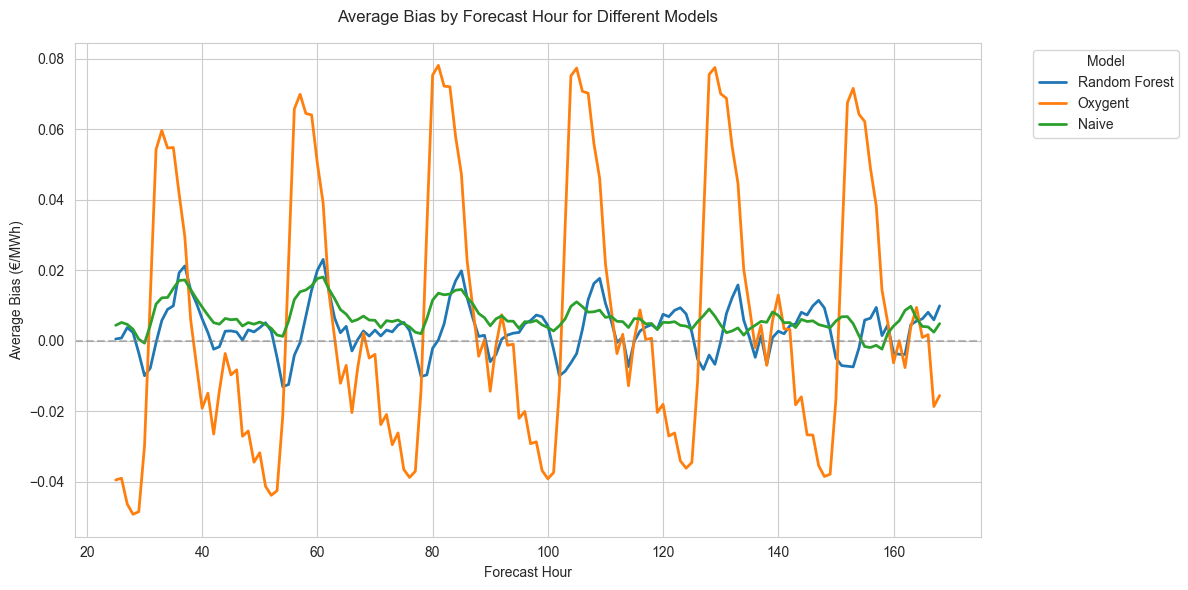

In [14]:
# Calculate mean bias per forecast hour for each model
bias_by_hour = pd.DataFrame({
    'Random Forest': df.groupby('forecast_hour')['bias_predicted_Price'].mean(),
    'Oxygent': df.groupby('forecast_hour')['bias_oxygent_price'].mean(),
    'Naive': df.groupby('forecast_hour')['bias_naive_price'].mean()
})

# Create the plot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Plot lines for each model
for column in bias_by_hour.columns:
    plt.plot(bias_by_hour.index, bias_by_hour[column], label=column, linewidth=2)

# Add horizontal line at y=0
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

# Customize the plot
plt.title('Average Bias by Forecast Hour for Different Models', fontsize=12, pad=15)
plt.xlabel('Forecast Hour', fontsize=10)
plt.ylabel('Average Bias (€/MWh)', fontsize=10)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

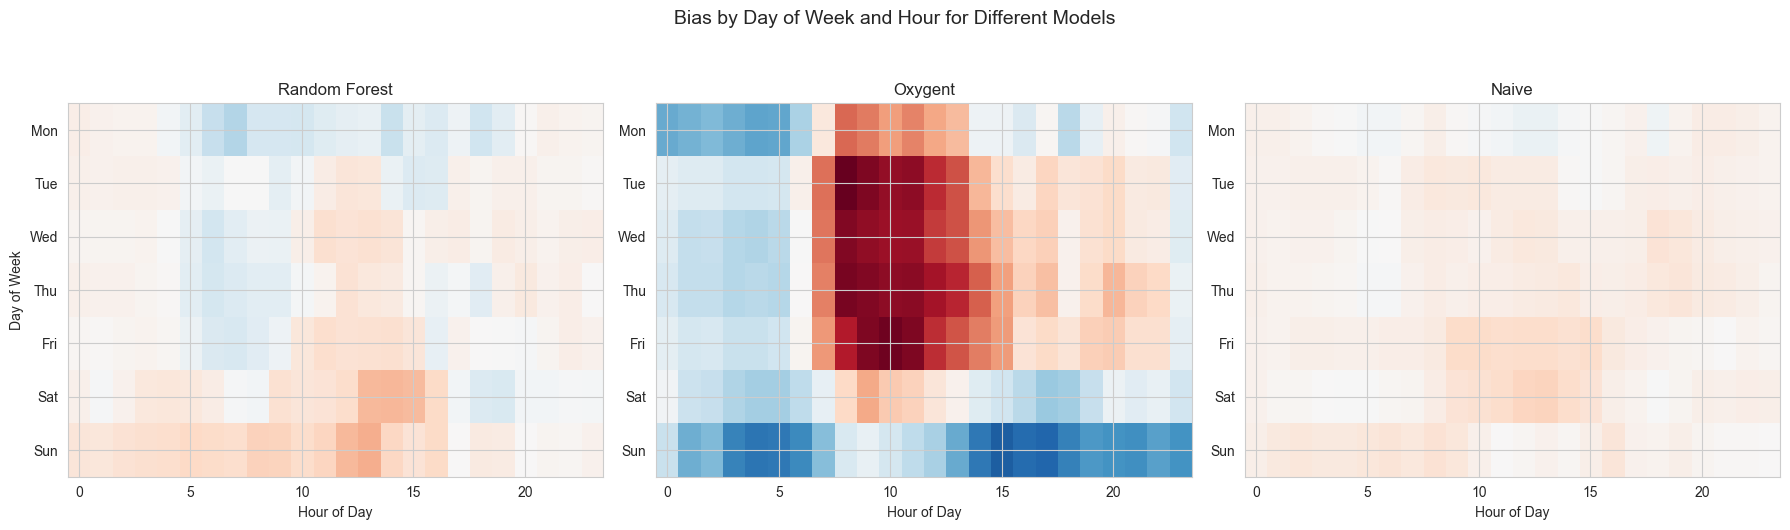

In [20]:
# Convert target_datetime to datetime and extract day of week and hour
df['day_of_week'] = pd.to_datetime(df['target_datetime']).dt.dayofweek
df['hour'] = pd.to_datetime(df['target_datetime']).dt.hour

# Calculate mean bias per day and hour for each model
bias_by_dayhour = pd.DataFrame()
for day in range(7):
    for hr in range(24):
        mask = (df['day_of_week'] == day) & (df['hour'] == hr)
        bias_by_dayhour.loc[f"{day}_{hr}", 'Random Forest'] = df[mask]['bias_predicted_Price'].mean()
        bias_by_dayhour.loc[f"{day}_{hr}", 'Oxygent'] = df[mask]['bias_oxygent_price'].mean()
        bias_by_dayhour.loc[f"{day}_{hr}", 'Naive'] = df[mask]['bias_naive_price'].mean()

# Create heatmap subplots for each model
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Bias by Day of Week and Hour for Different Models', fontsize=14, y=1.05)

models = ['Random Forest', 'Oxygent', 'Naive']
day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Calculate global vmax for symmetric color scaling
vmax = max(abs(bias_by_dayhour.min().min()), abs(bias_by_dayhour.max().max()))

for i, (model, ax) in enumerate(zip(models, axes)):
    # Reshape data for heatmap: rows=days, columns=hours
    data = np.array([bias_by_dayhour[model][bias_by_dayhour.index.str.startswith(f"{d}_")].values for d in range(7)])
    ax.imshow(data, aspect='auto', cmap='RdBu_r', vmin=-vmax, vmax=vmax)
    ax.set_title(model)
    ax.set_yticks(range(7))
    ax.set_yticklabels(day_labels)
    ax.set_xlabel('Hour of Day')
    if i == 0:
        ax.set_ylabel('Day of Week')

plt.tight_layout()
plt.show()

legend: colour scheme runs from -0.10 to + 0.10 € (darkest blue to darkest red)

## Model Performance Comparison

### Comparison Strategy

To evaluate the effectiveness of our Random Forest-based price forecasting model, we benchmarked its performance against two reference models: a naive model (using a simple persistence strategy) and an external benchmark model (Oxygent). The assessment focuses on three key aspects: overall forecast accuracy (Root Mean Squared Error, RMSE), bias across the forecast horizon, and practical utility in identifying the most and least expensive hours for electricity consumption.

---

### Overall Performance (RMSE)

The Random Forest model consistently outperforms both the naive and Oxygent models in terms of RMSE, indicating more accurate price predictions across the entire test set. RMSE values were calculated for each model using all available forecasted hours, providing a robust measure of average prediction error. This demonstrates the added value of the Random Forest approach over both simple and external benchmarks.

---

### Bias Analysis Across the Forecast Horizon

To further understand model behavior, we analyzed the bias (mean prediction error) as a function of the forecast horizon (in hours). The Random Forest model exhibits lower and more stable bias across different forecast horizons compared to the reference models, suggesting that its predictions are less systematically over- or underestimating actual prices. This stability is crucial for operational planning, as it reduces the risk of persistent over- or under-forecasting at specific lead times.

---

### Practical Performance: Identifying Cheapest and Most Expensive Hours

Beyond aggregate error metrics, we assessed each model’s ability to identify the 4 cheapest and 4 most expensive hours per day—a practical task for optimizing consumption or trading strategies. The Random Forest model achieves a higher average overlap with the actual cheapest and most expensive hours, and its selected hours are closer in price to the true optimal periods. This demonstrates that the model’s predictions are not only statistically accurate but also actionable in real-world decision-making contexts.

---

### Time-Dependent Error Patterns

To explore potential time-dependent error patterns, a bias heatmap by day of the week and hour of the day will be included. This visualization will help identify if certain periods (e.g., specific weekdays or hours) are associated with systematic over- or under-prediction, providing insights for further model refinement.

---

### Illustrative Example: Representative Week

Finally, a representative example week will be presented, showing model predictions versus actual prices for a range of `target_datetime` values within a single forecast run. This example will illustrate the day-to-day and hour-to-hour performance of each model, highlighting strengths and any remaining challenges in real-world forecasting scenarios.

---

**In summary, the Random Forest model demonstrates superior accuracy, lower bias, and greater practical utility compared to both the naive and Oxygent benchmarks, making it a robust choice for electricity price forecasting.**

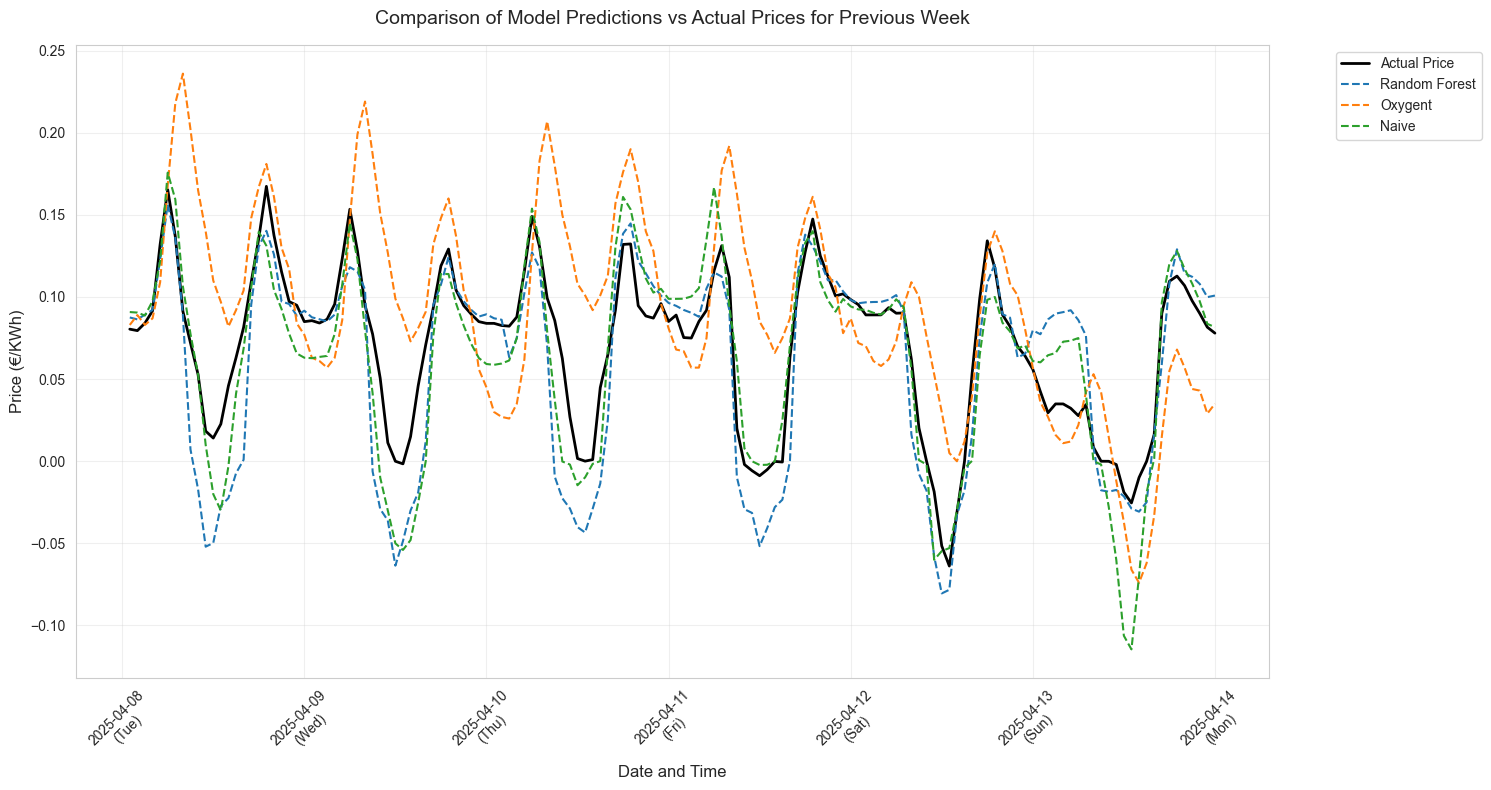


Summary Statistics for Previous Week:

Random Forest:
RMSE: 0.0325
Bias: -0.0120

Oxygent:
RMSE: 0.0569
Bias: 0.0223

Naive:
RMSE: 0.0277
Bias: -0.0079


In [35]:
# Select data from 6 days earlier than the last week
second_last_week = df[df['run_date'] == df['run_date'].unique()[-7]]  # -7 instead of -1
second_last_week = second_last_week.sort_values('target_datetime')

plt.figure(figsize=(15, 8))

# Plot actual prices
plt.plot(pd.to_datetime(second_last_week['target_datetime']), second_last_week['actual_Price'], 
         label='Actual Price', color='black', linewidth=2)

# Plot model predictions
plt.plot(pd.to_datetime(second_last_week['target_datetime']), second_last_week['predicted_Price'], 
         label='Random Forest', linestyle='--')
plt.plot(pd.to_datetime(second_last_week['target_datetime']), second_last_week['oxygent_price'], 
         label='Oxygent', linestyle='--')
plt.plot(pd.to_datetime(second_last_week['target_datetime']), second_last_week['naive_price'], 
         label='Naive', linestyle='--')

plt.title('Comparison of Model Predictions vs Actual Prices for Previous Week', 
          fontsize=14, pad=15)
plt.xlabel('Date and Time', fontsize=12)
plt.ylabel('Price (€/KWh)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Format x-axis to show date and weekday
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n(%a)'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print summary statistics for this period
print("\nSummary Statistics for Previous Week:")
print("===========================================")
for model in ['Random Forest', 'Oxygent', 'Naive']:
    if model == 'Random Forest':
        pred_col = 'predicted_Price'
    elif model == 'Oxygent':
        pred_col = 'oxygent_price'
    else:
        pred_col = 'naive_price'
        
    rmse = np.sqrt(mean_squared_error(second_last_week['actual_Price'], second_last_week[pred_col]))
    mae = mean_absolute_error(second_last_week['actual_Price'], second_last_week[pred_col])
    bias = (second_last_week[pred_col] - second_last_week['actual_Price']).mean()
    
    print(f"\n{model}:")
    print(f"RMSE: {rmse:.4f}")
    print(f"Bias: {bias:.4f}")